# Baeysian 2D model 

In [1]:
import numpy as np 
import pandas as pd 
import emcee 
import matplotlib.pyplot as plt 
from transit import occultnonlin, occultquad
from scipy.optimize import curve_fit
from interpolation import lc_interpolate_v2, test_func

### Line Fits
Try out the algorithm by fitting a line

Text(0, 0.5, 'y')

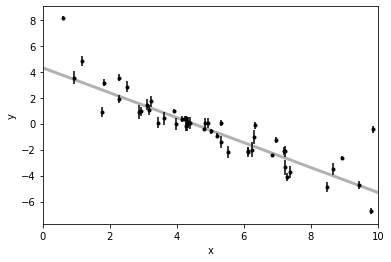

In [30]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [31]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


Text(0, 0.5, 'y')

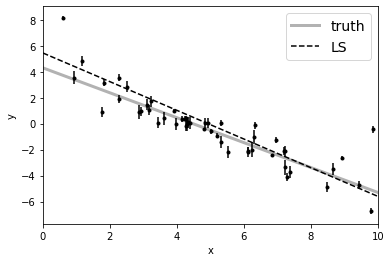

In [32]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Text(0, 0.5, 'y')

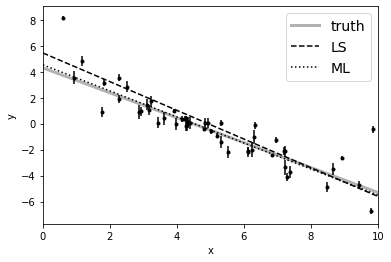

In [33]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [34]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:07<00:00, 630.54it/s]


State([[-0.94169902  4.33855735 -0.90287273]
 [-1.04379483  4.71942172 -1.02561355]
 [-1.00483302  4.52046151 -0.85424814]
 [-1.05569013  4.72082342 -0.70205919]
 [-1.05507088  4.70104476 -0.85035533]
 [-0.96581469  4.38838645 -0.73063892]
 [-1.04629992  4.66476627 -0.77458393]
 [-1.02711546  4.69185464 -1.08075342]
 [-0.96226982  4.27939785 -0.83659995]
 [-1.13403486  5.10014632 -0.96801566]
 [-1.05203683  4.73755794 -0.58123002]
 [-1.07403456  4.76613105 -0.74463711]
 [-0.95969885  4.29690917 -0.74174859]
 [-1.01168135  4.66389346 -0.86242673]
 [-1.02717734  4.6013357  -0.89852774]
 [-1.15635544  5.23316573 -0.7615383 ]
 [-1.01353199  4.62922537 -0.65092483]
 [-1.09759597  5.00861121 -0.76352872]
 [-0.95513939  4.38732123 -0.78072125]
 [-1.11290136  5.07052444 -0.98774449]
 [-0.91461392  4.09924748 -0.6182552 ]
 [-1.03519069  4.67203984 -0.93267614]
 [-1.02273582  4.61163148 -0.64883326]
 [-0.90058962  4.08544775 -0.58747388]
 [-0.93440466  4.21508671 -0.56931105]
 [-1.02984499  4.69

Text(0.5, 0, 'step number')

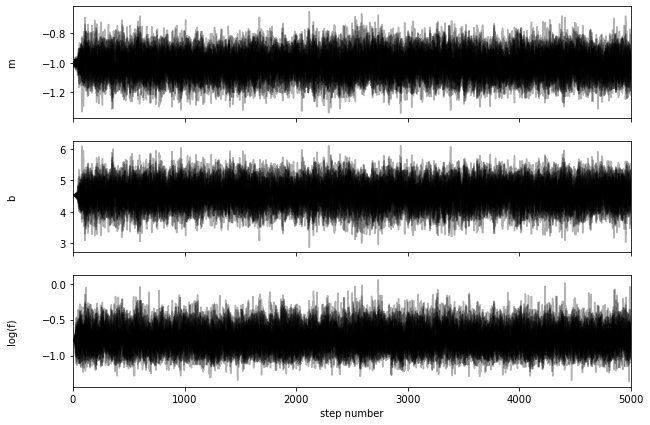

In [35]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

### 3D Model fit
Here we try out the same exercise from a 3D Model... just something so that we can try out the procedure with less computation time

In [ ]:
#here's the planet model
def new_plar(ph,p,u1,u2,rorb,imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a)

#here's some generated synthetic data
ph = np.linspace(-0.5,0.5,300)
fl = new_plar(ph, 0.11,0.23,0.34,3.12,0.0)
fl = fl*np.random.normal(1,0.0005,300)
fl_err = np.abs(np.random.normal(0,0.0005,300))


plt.errorbar(ph,fl,fl_err,None, marker='.', ls='None')
plt.show()

In [ ]:
# setting up the priors code
def log_prior_pl(theta):
    p, u1, u2, rorb= theta
    if 0 < p < 1 and 0.2 < u1 < 0.3 and 0.3 < u2 < 0.4 and 0 < u1+u2 < 1 and 1 < rorb < 5:
        return 0.0
    return -np.inf

def log_likelihood_pl(theta, ph, fl, fl_err):
    p, u1, u2, rorb = theta
    model = new_plar(ph, p, u1, u2, rorb, 0)
    return -0.5 * np.sum(((fl - model)/fl_err) ** 2)
    #sigma2 = fl_err ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((fl - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_pl(theta, ph, fl, fl_err):
    lp = log_prior_pl(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_pl(theta, ph, fl, fl_err)

In [ ]:
initial = np.array([0.1,0.2,0.4,3])
nwalkers = 32
ndim = 4
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_pl, args=(ph, fl, fl_err)
)
sampler.run_mcmc(p0, 3000, progress=True)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
import corner
labels = ["p", "u1","u2","rorb","b"]
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[0.11,0.23,0.34,3.12]
);

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print(0.11,0.23,0.34,3.12,0.0)

In [ ]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        a,b,c,d = i
        mod = new_plar(ph,a,b,c,d,0.0)
        models.append(mod)
    spread = 3*np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(5000,flat_samples)

plt.errorbar(ph, fl, fl_err, capsize=0, color='gray', ls='None', zorder=0)
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(ph,med_model-spread,med_model+spread,color='red',alpha=0.5,label=r'$3\sigma$ Posterior Spread', zorder=1)
plt.plot(ph, new_plar(ph, 0.11,0.23,0.34,3.12,0.0), "k", label="truth")
#plt.plot(ph, new_plar(ph, 0.099,0.711,0.713,2.89,0.0), "k", label="est")
plt.legend(fontsize=14)
plt.title('True: Rpl:0.11 Rorb:3.12 u1:0.23 u2:0.34 b:0 \n Fit: Rpl:0.107 Rorb:3.07 u1:0.06 u2:0.85 b:0.0')

plt.xlabel("x")
plt.ylabel("y")
#plt.savefig('baeysiantest.png')

### 2D Model Fit
Now we generalize the interpolation routine to include 2D models

(10, 10, 5, 10, 3, 300) (10, 10, 300)


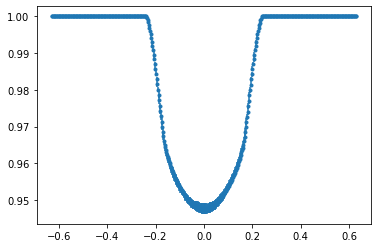

In [2]:
# generate grid
points, vals, phases = test_func()

#here's some generated synthetic data
df = pd.read_csv('2d3d_0.2R_limb_circ_corr.csv', sep=',')
ph = df['frame']
fl = df['2d']
fl_err = df['2dstd']

plt.errorbar(ph,fl,fl_err,None, marker='.', ls='None')
plt.show()

In [3]:
# setting up the priors code
def log_prior_2d(theta):
    p, rorb, u1, u2= theta
    if 0 < p < 1 and 0 < u1 < 1 and 0 < u2 < 1 and 1 < rorb < 10:
        return 0.0
    return -np.inf

def log_likelihood_2d(theta, ph, fl, fl_err):
    p, rorb, u1, u2 = theta
    model = lc_interpolate_v2(ph, p, rorb, 0.0001, u1, u2, points,vals,phases)
    return -0.5 * np.sum(((fl - model)/fl_err) ** 2)
    #sigma2 = fl_err ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((fl - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_2d(theta, ph, fl, fl_err):
    lp = log_prior_2d(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_2d(theta, ph, fl, fl_err)

In [4]:
def temp_intepolate(ph,rpl,rorb,u1,u2):
    return(lc_interpolate_v2(ph,rpl,rorb,0.0001,u1,u2,points,vals,phases))

popt, pcov = curve_fit(temp_intepolate, ph, fl, bounds=([0,1,0,0], [1,5,0.9,0.9]))

print(popt)

[2.00275104e-01 4.91114157e+00 6.05627994e-01 5.51859753e-15]


In [11]:
initial = np.array([0.23,9,0.66,0.05])
#initial = np.array(popt)
nwalkers = 8
ndim = 4
#p0 = [np.array(initial) + 2*1e-2 * np.random.randn(ndim) for i in range(nwalkers)]
p0 = [np.random.normal(n,min([np.abs(n-0),np.abs(n-1)])/4,nwalkers) if(n<1) else np.random.normal(n,min([np.abs(n-1),np.abs(n-10)])/4,nwalkers) for n in initial]
p0 = np.transpose(np.array(p0))

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_2d, args=(ph, fl, fl_err*0.1)
)
sampler.run_mcmc(p0, 200, progress=True)

100%|██████████| 200/200 [04:22<00:00,  1.31s/it]


State([[0.21097296 9.01793872 0.80144387 0.04029701]
 [0.27205315 9.24605058 0.53588477 0.0567294 ]
 [0.17384334 9.19166204 0.77228331 0.03593284]
 [0.21631824 9.18968053 0.6988254  0.04965472]
 [0.26349427 8.96588759 0.71207075 0.04327867]
 [0.27609013 8.98125725 0.54831231 0.08182799]
 [0.21821585 9.01752377 0.79533416 0.03358536]
 [0.44650323 8.29352444 0.50513312 0.0446917 ]], log_prob=[ -4363456.93060043               -inf  -5114558.67517564
  -4377698.6784083                -inf               -inf
  -4401417.41513438 -72384771.32478908], blobs=None, random_state=('MT19937', array([2348941552, 2814043267, 2820208545, 2901971513,  991562888,
       2179137083, 3318554960, 3138965742,  814460384, 3837100356,
       3567726719, 3227940369, 3565538936, 1401720172, 1890359573,
        394861332, 1934362022, 3324269417, 3596179057, 3633239521,
        896699449, 3600147039, 2383348447, 2350431513,  272481777,
       2935674117, 3042899623, 2725179018,  753267017, 4189603381,
       2688

Text(0.5, 0, 'step number')

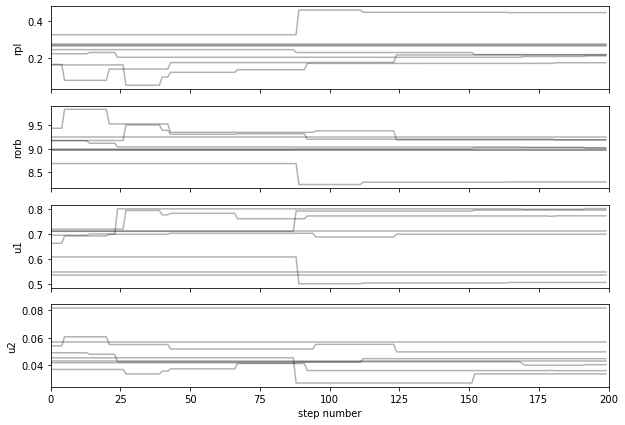

In [12]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rpl","rorb","u1","u2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

(1520, 4)


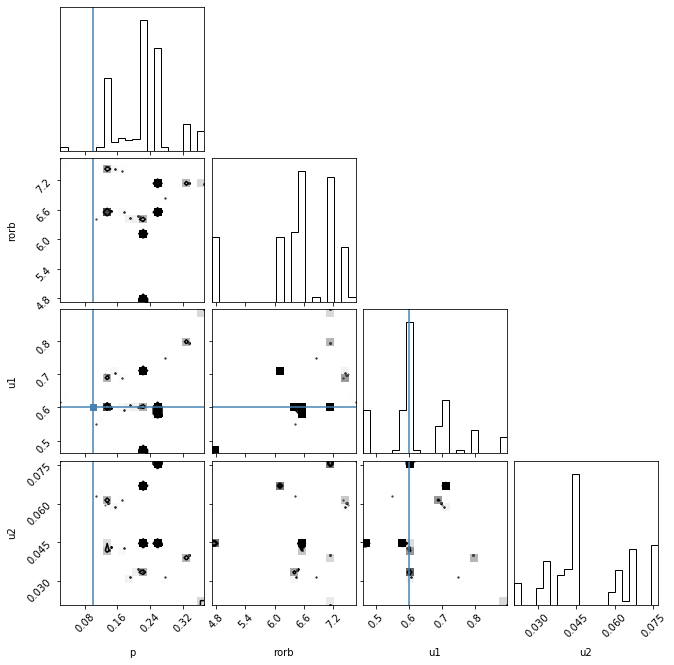

In [7]:
import corner
labels = ["p","rorb", "u1","u2"]
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[0.1,2,0.6,0]
)

In [8]:
from IPython.display import display, Math

popt_baeys =[]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    popt_baeys.append(mcmc[1])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

#0.2,3.11,0.55,0.1


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

done


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


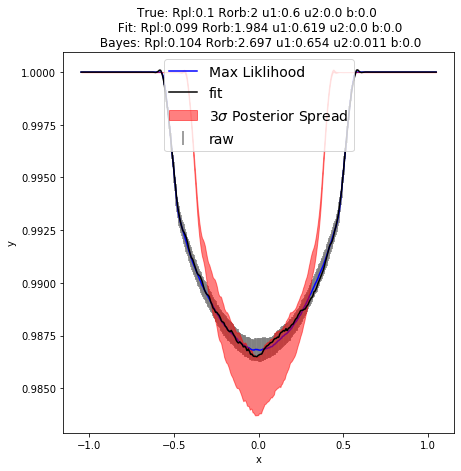

In [128]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    #np.random.shuffle(thetas)
    for i in thetas[1800:1850]:
        a,b,c,d = i
        mod = lc_interpolate_v2(ph,a,b,0.001,c,d,points, vals, phases)
        models.append(mod)
    spread = 0.1*np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(2000,flat_samples)
print('done')

plt.figure(figsize=(7,7))
plt.errorbar(ph, fl, fl_err, capsize=0, color='gray', ls='None', zorder=0, label='raw')
plt.plot(ph, fl, color='blue', zorder=0, label='Max Liklihood')
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(ph,med_model-spread,med_model+spread,color='red',alpha=0.5,label=r'$3\sigma$ Posterior Spread', zorder=1)
#plt.plot(ph, lc_interpolate_v2(ph, 0.1,2,0,0.6,0, points, vals, phases), "k", label="truth")
plt.plot(ph, temp_intepolate(ph, *popt), "k", label="fit")
#plt.plot(ph, new_plar(ph, 0.099,0.711,0.713,2.89,0.0), "k", label="est")
plt.legend(fontsize=14)
plt.title('True: Rpl:0.1 Rorb:2 u1:0.6 u2:0.0 b:0.0 \n Fit: Rpl:'+str(np.around(popt[0],3))+' Rorb:'+str(np.around(popt[1],3))+' u1:'+str(np.around(popt[2],3))+' u2:'+str(np.around(popt[3],3))+' b:0.0\n Bayes: Rpl:'+str(np.around(popt_baeys[0],3))+' Rorb:'+str(np.around(popt_baeys[1],3))+' u1:'+str(np.around(popt_baeys[2],3))+' u2:'+str(np.around(popt_baeys[3],3))+' b:0.0')

plt.xlabel("x")
plt.ylabel("y")
plt.savefig('curvefit2.png')